# Docler Holding - Machine Learning homework

## 0) Dataset exploration

In [11]:
# Dataset exploration

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image
Image("image/formulation.png")


trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified


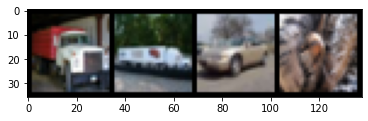

Label: truck    truck      car      cat


In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, labels = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)
print('Label:', '    '.join('%5s' % classes[labels[j]] for j in range(4)))


__Takeaways__:
* Similar to Imagenet
* Smaller, lower resolution images
* Balanced classes

## Model selection

__Requirements__: 
   * fast to train, fast prediction 
   * good accuracy
   * off the shelf method
   * has pretrained weights on ImageNet
   * scalable to bigger model
   
Main source for model comparison: Benchmark analysis of representative deep neural network architectures (Bianco et al., 2018)
                     
#### VGG
* VGG is widely used (results are easy to compare)
* elegant structure
* too many parameters
* slow to train

#### ResNet
* thinner and deeper than VGG, less parameters
* better accuracy than VGG, AlexNet and GoogleNet 
* has fairly even accuracy scores across categories (An Analysis Of Convolutional Neural Networks For Image Classification, (Sharma et al., 2018)) --> Important for us
* easy to scale, has many variants

#### MobileNet-V2

* MobileNetV2, usually less accurate than ResNet50
* Our object in this project is not to be able to run it on mobile device

#### DenseNet
* Could be an alternative, comparable accuracy to ResNet
* For similar accuracy, more parameters are required
* Longer inference time than similar-performing ResNet



## Selected architecture: ResNet



## 1) Subset selection

__What is an informative subset of the training data?__

--> Core-set selection problem

How do we select a subset of the data so the prediction accuracy remains as high as possible?



<img img style="float: left;" src="images/formulation.png" width="650">

__Selection via proxy: Efficient data selection for deep learning (Coleman et al., 2019)__


Pros:
* computationally efficient: 
* small proxy model, 
* good Spearman correlation between small and big models on metrics like uncertainty 

Main steps: 
1. Train a smaller proxy model
2. Select the subset of the data that is "hard" based on some criteria
3. Train bigger model on the core-set


__We could use ResNet-18 as a proxy model and train ResNet-50 on the Subset__


Selection algorithm: forgetting events (An empirical study of example forgetting during deep learning (Toneva et al, 2019))
Main idea: 
1. During training for each sample calculate how often a model learns and than forgets how to classify it correctly (forgetting event)
2. Select the hardest examples: samples that have never been learnt or forgotten the most times



<img style="float: left;" src="images/forgetting_events.png" width="320">

## 2) Network modifications

1. I've started from a pretrained network on the ImageNet class and modified the decision making MLP, so it has 11 output neurons (10 for prediction, 1 for the ones). 

2. If trained with freezed weights, I set requires_grad=False for all weights in the convolutional architecture and skip connections, so only the decision-making MLP layers are trainable. 

3. I've scaled up the CIFAR-10 images to 224x244 RGB pixels, so the inputs will resemble the ImageNet inputs (with lower resolution of course). 

4. I created a custom model from an existing base neural network. It splits the output activation layer into two streams. The first 10 neurons are responsible for the class prediction, the last one is clamped from below and above to 1.

5. Later we only calculate the loss for (and backprop through) the prediction neurons.

In [13]:
import torchvision.models as models
import torch.nn as nn


def set_parameter_requires_grad(model, freeze_weights):
    if freeze_weights:
        for param in model.parameters():
            param.requires_grad = False


class MyModel(torch.nn.Module):
    # We initialize from a base model
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base_model = base_model
    
    def forward(self, x):
        out = self.base_model(x)

        # We split output activations to 2 streams and clamp the last neuron from below and above
        predictions = out[:, :-1]
        ones = out[:, -1].clamp(min=1, max=1)
        
        return predictions, ones


def initialize_model(model_type, num_classes, use_pretrained, freeze_weights, dropout, device):
    

    model = None

    if model_type == "resnet18":
        """ Resnet18
        """
        model = models.resnet18(pretrained = use_pretrained)
    elif model_type == 'resnet50':
        """ Resnet50
        """
        model = models.resnet50(pretrained = use_pretrained)

    else:
        print("Invalid model type, exiting...")
        exit()
    
    set_parameter_requires_grad(model, freeze_weights)
    num_ftrs = model.fc.in_features
    if dropout:     
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(64, num_classes+1)
            )
    else:
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes+1)
            )

    
    # We add the extra strem for ones 
    extended_model = MyModel(model)

    extended_model = extended_model.to(device)

    return extended_model


In [14]:
base_model = models.resnet50()
my_model = MyModel(base_model)

# testing ones during training time
my_model.train()
inputs, labels = next(iter(trainloader))
predictions, ones = my_model(inputs)
assert(len(ones) == len(predictions)) 
assert(ones.dtype == predictions.dtype)

print(f'At training time ones = {ones} \n')

# testing ones during inference time

my_model.eval()
inputs, labels = next(iter(trainloader))
predictions, ones = my_model(inputs)
assert(len(ones) == len(predictions)) 
assert(ones.dtype == predictions.dtype)

print(f'At test time ones = {ones}')

At training time ones = tensor([1., 1., 1., 1.], grad_fn=<ClampBackward>) 

At test time ones = tensor([1., 1., 1., 1.], grad_fn=<ClampBackward>)


## 3) Training, optimization


Starting ideas: 

* Since our dataset is relatively small (and after selection it will become even smaller), transfer learning could come handy
* Imagenet is a task that is very similar, we can leverage the wide range of pretrained models available

### Training the proxy model (ResNet-18)



__Best results__:


* Preloaded weights (previously trained on ImageNet)
* Data augmentation: random cropping and horizontal flipping of training images (makes the task much harder)
* Normalizing images (same way as they were normalized while training on ImageNet)
* All weights are trainable
* 20 epochs are enough for convergence
* 92.1% test accuracy
* I used this model's behaviour as input for the subset selection algorithms



__ResNet-50__: 

I trained the bigger model on the original dataset, for sanity check and later comparison


* 93.0% test accuracy
* trained for 80 epochs
* preloaded weights
* no weight freezing

* sanity comparison: 93.0% for Resnet-18, 93.6% for ResNet-50 (https://github.com/kuangliu/pytorch-cifar)
* --> ResNet-18 is a good proxy

<img src="images/proxy.png">

### Forgetting events stats

* Majority of pictures were forgotten 1x, 2x or 3x 
* 103 images were never learnt
* 1k forgetting events subset will consist of images that have never been classified correctly(~10%) and images that have been forgotten 6,7 or 8 times.


<img src="images/forgetting_hist.png">

### forgetting events selection
* 35% test accuracy
* overfitting
* looks poor, can we do better?
* I have tried resuming the training, no significant change in result

<img src="images/fe.png">

__random selection__
* always good to check against random
* much higher accuracy
* still overfits
* Why could it be? --> hardest 1k examples may be too hard for the model the get a good understanding of the categories

<img src="images/random.png">

__reverse forgetting events__
* Why not try learning from the easiest examples
* best performance so far
* still overfits

<img src="images/rev_fe.png">

## Discussion


* SVP paper tackles the problem of how we can leave out some small portion (e.g. 30%) of the data so the performance is not impaired 
* With 1k samples we would leave out 98% of the data 
* We might have to switch our perspective: which sample is easy but informative enough so we can have a vague idea about the decision boundaries
* Hardest examples might not be a good representation of the given cathegory

## Tuning, combattig overfitting ##

Using the best-performing selection method (reverse forgetting-events), let's try to increase the performance

* Training accuracy is high, but train-validation gap is big --> let's try to combat overfitting
* Freezing all convolutional layers, only finetuning the fc layers
* Better accuracy
* Still overfits

<img src="images/rev_fe_freeze.png">

__Let's try even more regularization__
* Adding dropout layers to the linear layers in fc
* less overfitting but accuracy drops


<img src="images/freeze_dropout.png">

__Summary of accuracy scores of different models and selection methods__

<img src="images/model_comparison.png">

### Other KPIs

__Training times__:

Disclaimer: tests were conducted with Google Colab's GPU's. There is no way to choose what type of GPU you can connect to at any given time (you might get different kind of gpu at every time you connet), so measurements can be unreliable and should be taken as proxy

On the original CIFAR-10 Dataset
* Proxy modell (ResNet18 for less epochs): 1h40m
* ResNet-50: 5h52m

Selection times (average of 3 runs)
* forgetting_events: 8.3s
* reverse_forgetting events 9.1s
* random 0.8s

Training on the 1k core-set (used the best perfroming _rev_fe_freeze_ model)
* 53m 

Inference time (_rev_fe_freeze_ ):
* on cpu: 313 ms
* on gpu: 17 ms 
(used info and code from here to measure gpu inference: https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f)


__Model size__:
96,5 MB




## There should be no object recognition project without testing it on your own image

predicted: dog


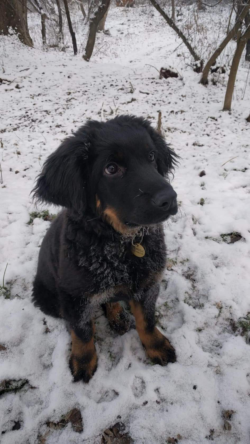

In [22]:
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage
import PIL.Image as Image

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform_eval = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


def try_your_picture(pic_name, modelname, basemodel_arch):
    # for 
    
    test_model = initialize_model(basemodel_arch, 10, False, False, False, 'cpu')
    test_model.load_state_dict(torch.load(f"../trained_models/{modelname}.pth", map_location=torch.device('cpu')))
    test_model.eval()
    
    im = Image.open('test_pics/' + pic_name)
    scale_to_show = transforms.Resize(250)
    scaled = scale_to_show(im)

    down_scale = transforms.Resize((32, 32))
    im = transform_eval(down_scale(im)) 
    
    out, ones = test_model(im.unsqueeze(0))
    _, pred = torch.max(out, 1)
    print(f"predicted: {classes[int(pred)]}")
    display(scaled)
    
    
try_your_picture('borisz.jpeg', 'resnet18_proxy', 'resnet18')

## 4) 80 hours project

* Freezing only parts of the convolutional backbone, make upper layers trainable
* L2, lasso regularization
* Testing different model architecture, e.g. DenseNet
* Hiperparameter optimization: learning rate, different optimizer(SGD, RMSProp)
* Trying out other Subset selection methods (least confidence uncertainty sampling, max entropy sampling, greedy k-means)
* Evaluation metrics: per class accuracy, top_k_accuracy, measuring throughput




## 5) Model deployment

Building a Docker image
